In [1]:
#importing required packages 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
#matplotlib.style.use('ggplot')
from xgboost import XGBClassifier


plt.style.use('seaborn')
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE


Bad key "text.kerning_factor" on line 4 in
D:\conda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
D:\conda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\conda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be import

In [3]:
#reading source data
application_train_df=pd.read_csv('application_train.csv')

credit_card_df_df=pd.read_csv('credit_card_balance.csv')

previous_application=pd.read_csv('previous_application.csv')


# Previous Application Data

- Calculating Aggreggated Features from the previous_application Dataset

In [6]:
## count the number of previous applications for a given ID
prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['P_' + col for col in prev_apps_avg.columns]

application_train_df = application_train_df.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')



# Credit Card Data
- Calculating Aggreggated Feature from the credit_card Dataset

In [8]:
### count the number of credit card dataset for a given ID
nb_prevs = credit_card_df_df[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_df_df['SK_ID_PREV'] = credit_card_df_df['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_df_df.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
application_train_df = application_train_df.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

# Data Preprocessing

- Five Number Summary
- Missing Values Check
- Skewness Analysis
- Correlation Analysis 
- Data Distribution Check


## Missing Values Check

In [10]:
#Five Number Summary
categorical_variable_stat=application_train_df.describe(include=[np.object])
numerical_variable_stat=application_train_df.describe(include=[np.number])

In [11]:
numerical_variable_stat

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,cc_bal_AMT_RECEIVABLE_PRINCIPAL,cc_bal_AMT_RECIVABLE,cc_bal_AMT_TOTAL_RECEIVABLE,cc_bal_CNT_DRAWINGS_ATM_CURRENT,cc_bal_CNT_DRAWINGS_CURRENT,cc_bal_CNT_DRAWINGS_OTHER_CURRENT,cc_bal_CNT_DRAWINGS_POS_CURRENT,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,86905.000000,86905.000000,86905.000000,61140.000000,86905.000000,61140.000000,61140.000000,86905.000000,86905.000000,86905.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,68748.971932,70981.686227,70985.788979,0.566241,1.541650,0.007255,1.750056,10.202294,4.209093,0.126870
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,105308.965690,108441.254297,108442.434134,0.880410,3.693164,0.047259,4.274905,13.539328,44.602274,10.034009
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,-2930.232558,-2930.232558,-2930.232558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.062993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,25546.994118,26559.052500,26559.800000,0.270833,0.216216,0.000000,0.045455,3.888889,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,94436.126591,97903.575000,97909.024091,0.731343,1.324324,0.000000,1.428571,15.366667,0.000000,0.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,884547.880714,913096.639286,913096.639286,35.000000,118.250000,2.000000,118.250000,73.062500,1386.947917,1309.600000


In [12]:
categorical_variable_stat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


## Missing Value Analysis

In [13]:
#getting the numeric dataset
application_train_df_numeric=application_train_df._get_numeric_data()
#Missing Values Check
columns_with_missing_values=pd.DataFrame()
columns_with_missing_values['columns_name']=application_train_df_numeric.columns

#caculating missing values percentage
columns_with_missing_values["missing_value"]=0
for i in application_train_df_numeric.columns:
    columns_with_missing_values["missing_value"][columns_with_missing_values['columns_name']==i]=application_train_df_numeric[i].isnull().sum()/len(application_train_df_numeric[i])*100

#sorting the missing_value    
columns_with_missing_values=columns_with_missing_values.sort_values(by=['missing_value'],ascending=False)

#Rounding off the missing_value
columns_with_missing_values['missing_value']=columns_with_missing_values['missing_value'].round()

D:\conda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


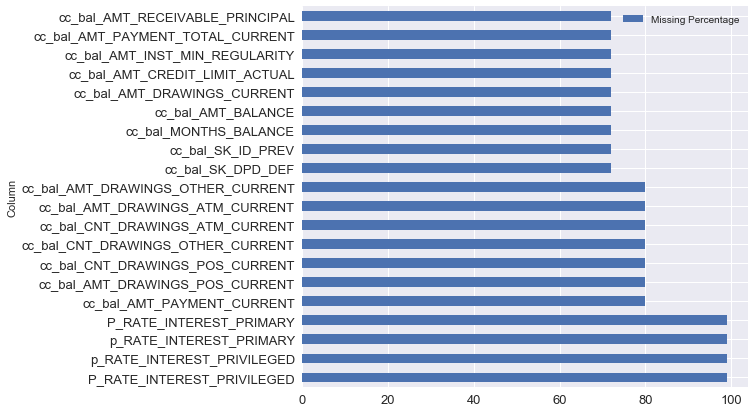

In [14]:
columns_with_missing_values.columns=['Column','Missing Percentage']

#ploting Missing Values
missing_value_plot = columns_with_missing_values.head(20).plot.barh(x='Column', y='Missing Percentage',figsize=(8,7),fontsize=13)


In [15]:
#removing the columns with 60% missing values
application_train_df_numeric=application_train_df_numeric.drop(list(columns_with_missing_values['Column'][columns_with_missing_values['Missing Percentage']>60.0]),axis=1)


### Imputing Missing value  with Mean value

In [16]:

#KNN and other methods can be used for data imputation use it later 
#application_train_df_numeric=application_train_df_numeric_1

#dropping the customer Id 
application_train_df_numeric=application_train_df_numeric.drop('SK_ID_CURR', axis=1)

#replacing the missing value with the mean of the column
application_train_df_numeric=application_train_df_numeric.fillna(application_train_df_numeric.mean())


## Data Distribution Check

In [17]:

#checking for skewness
#application_train_df_numeric.hist(alpha=0.5,figsize=(100, 50))    

# Encoding Categorical Features

In [18]:
#negative values to positive
#application_train_df_numeric=application_train_df_numeric.abs()

#concating the numeric and categorical dataframes
application_train_df=pd.concat([application_train_df.select_dtypes(include='O').reset_index(drop=True), application_train_df_numeric.reset_index(drop=True)], axis=1)

application_train_df_numeric=None
application_train_df_numeric_1=None

#droping dividing into X and Y datasets
y_application_train_df=application_train_df['TARGET']
x_application_train_df=application_train_df.drop('TARGET',axis=1)


#converting categorical label into one-hot encoding vectors
x_application_train_df=pd.get_dummies(x_application_train_df)

# Feature Engineering 

- Correlation Analysis
- Feature Important using Random Forest 


### Correlation Analysis

- Removing Corelated Features with a Threshold of 0.9

In [19]:
#calculating Correlation matrix among the features
correlation_matrix=x_application_train_df.corr()

#corelation threshold
threshold=0.9

#deleting the lower half of the matrix
upper_tri_correlation_matrix=correlation_matrix.where(np.triu(correlation_matrix, k=1).astype(np.bool))


#dropign features that are 90% corellated with each other
for i in upper_tri_correlation_matrix.columns:
    if(any(upper_tri_correlation_matrix[i]>=threshold)):
        x_application_train_df=x_application_train_df.drop(i,axis=1)

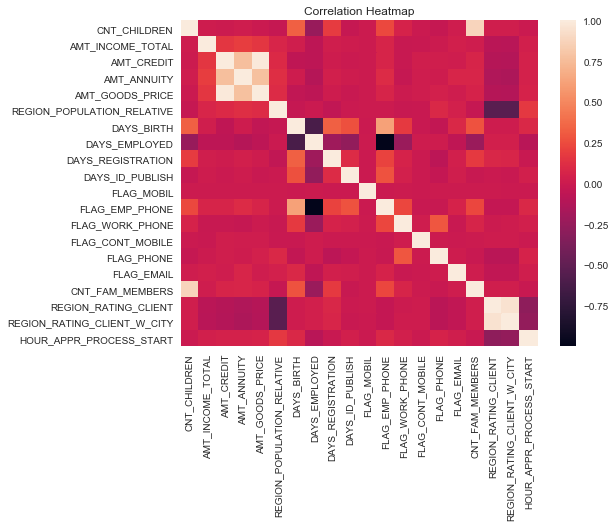

In [20]:
#ploting correlation
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(correlation_matrix.head(20)[list(correlation_matrix.columns[:20])])
plt.title('Correlation Heatmap');

## Feature Importance Using Random Forest

In [21]:
#Feature Selection using Random forest
rf = RandomForestClassifier(n_estimators = 500 , max_depth = 5, min_samples_leaf = 4, max_features = 0.5,n_jobs=5)
rf.fit(x_application_train_df,y_application_train_df)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=5,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [22]:
feature_dataframe=pd.DataFrame(columns=['Feature','Importance'])
feature_dataframe['Feature']=x_application_train_df.columns
feature_dataframe['Importance']=rf.feature_importances_
feature_dataframe=feature_dataframe.sort_values(by='Importance',ascending=False)

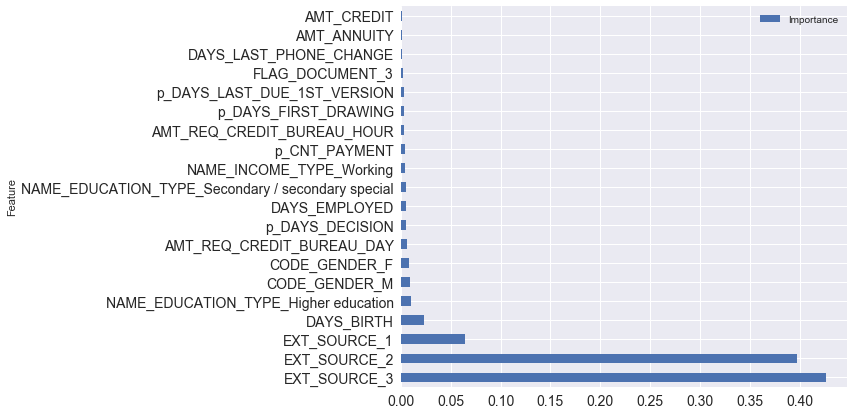

In [23]:
feature_dataframe.head(20).plot.barh(x='Feature', y='Importance',figsize=(8,7),fontsize=14)

In [58]:
#droping features with importance less than and equal to 0
x_application_train_df=x_application_train_df[list(feature_dataframe[feature_dataframe['Importance']>0]['Feature'])]

# Class Imbalance Handling

- Applied SMOTE to handle class imbalance

In [24]:
#shows the class imbalance in the dataset
y_application_train_df.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [25]:

#Running smote on feature with greater than 0 importance
sm = SMOTE(random_state=0)
x, y = sm.fit_resample(x_application_train_df, y_application_train_df)


D:\conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [61]:
#writing the Pre-processed X, Y dataset for the models
pd.DataFrame(x).to_csv('x.csv',index=False)
pd.DataFrame(y).to_csv('y.csv',index=False)